# Yield Mapping

In [1]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

This notebook demonstrates the process of yield mapping for agricultural data. We'll cover the following key steps:
1. Data preprocessing
2. Grid creation for interpolation
3. Inverse Distance Weighting (IDW)
- Appendix

In [2]:
filepath = 'Data/yield_data.gpkg'

In [3]:
# Read the .gpkg file and print its info
gdf = gpd.read_file(filepath)
print(gdf.info())
print(gdf.head())


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1906 entries, 0 to 1905
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date/Time    1906 non-null   datetime64[ms]
 1   Latitude     1906 non-null   float64       
 2   Longitude    1906 non-null   float64       
 3   Moisture     1906 non-null   float64       
 4   Speed        1906 non-null   float64       
 5   Yield_kg_m2  1906 non-null   float64       
 6   geometry     1906 non-null   geometry      
dtypes: datetime64[ms](1), float64(5), geometry(1)
memory usage: 104.4 KB
None
            Date/Time   Latitude  Longitude  Moisture  Speed  Yield_kg_m2  \
0 2022-08-31 16:26:39  44.850793  11.964952      36.8   4.71     6.268876   
1 2022-08-31 16:26:55  44.850615  11.964934      36.8   4.72    11.048160   
2 2022-08-31 16:27:10  44.850444  11.964928      36.8   4.12    13.061676   
3 2022-08-31 16:27:25  44.850285  11.964940      25.7   4.

## 1. Data Preprocessing

Data preprocessing is a crucial step in any data analysis pipeline. For our yield mapping task, we'll focus on two main aspects:

1. Standardization of the yield variable:
   We standardize the 'Yield_kg_m2' variable to have a mean of 0 and a standard deviation of 1. This process is needed for the implementation of the interpolation algorithm. It also mitigates the effect of outliers on our analysis.

2. Coordinate system transformation:
   We'll convert our data from a geographic coordinate system (EPSG:3857 - Web Mercator) to a projected coordinate system (UTM). This transformation is necessary for accurate spatial analysis at a local scale.

Let's proceed with these preprocessing steps:

In [4]:
# Standardize the Yield_kg_m2 variable
gdf['Yield_kg_m2'] = (gdf['Yield_kg_m2'] - gdf['Yield_kg_m2'].mean()) / gdf['Yield_kg_m2'].std()


In [5]:
print(gdf.crs)

EPSG:3857


The current coordinate reference system (CRS) is EPSG:3857 (Web Mercator projection),
while the 'Latitude' and 'Longitude' columns are in EPSG:4326 (WGS84). Both of these
are geographic coordinate systems that represent locations on a spherical Earth.

For our yield mapping purposes, we need to convert to a projected coordinate system
that represents the field as a flat surface. This conversion is appropriate and 
accurate for the following reasons:

1. Local scale: The agricultural field is relatively small compared to the Earth's
   surface, making the curvature negligible at this scale.
2. Precision: A flat projection will provide more accurate area and distance 
   calculations for our yield analysis.
3. Computational efficiency: Planar coordinates are easier to work with for 
   spatial analysis and visualization tasks.

We will select an appropriate projected CRS based on the field's location to 
ensure optimal accuracy for our yield mapping and spatial analysis.

In [6]:
from pyproj import CRS

# Create a boundary starting from the original set of points.
boundary = gdf.union_all().convex_hull
boundary_gdf = gpd.GeoDataFrame(geometry=[boundary], crs=gdf.crs)

# Determine the UTM zone directly from EPSG:3857
# We'll use the centroid of the boundary for this calculation
centroid_3857 = boundary.centroid
centroid_4326 = gpd.GeoSeries([centroid_3857], crs="EPSG:3857").to_crs("EPSG:4326")[0]
utm_zone = int((centroid_4326.x + 180) / 6) + 1
# Manually specify the UTM zone
utm_crs = CRS.from_string(f"+proj=utm +zone={utm_zone} +datum=WGS84 +units=m +no_defs")

# Transform both the dataset and the boundary directly to UTM
gdf_utm = gdf.to_crs(utm_crs)
boundary_utm = boundary_gdf.to_crs(utm_crs)

# Add a buffer to the boundary (5 meters)
buffered_boundary = boundary_utm.buffer(5)

# Extract X and Y coordinates from the UTM geometry
gdf_utm['X'] = gdf_utm.geometry.x
gdf_utm['Y'] = gdf_utm.geometry.y

# Verify the changes
print(f"UTM Zone: {utm_zone}N")
print(f"Original CRS: {gdf.crs}")
print(f"New CRS: {gdf_utm.crs}")
print(f"Columns in the new df: {gdf_utm.columns}")

UTM Zone: 32N
Original CRS: EPSG:3857
New CRS: +proj=utm +zone=32 +datum=WGS84 +units=m +no_defs +type=crs
Columns in the new df: Index(['Date/Time', 'Latitude', 'Longitude', 'Moisture', 'Speed',
       'Yield_kg_m2', 'geometry', 'X', 'Y'],
      dtype='object')


This code above performs coordinate reference system (CRS) transformation for yield mapping. It converts the data from Web Mercator (EPSG:3857) to an appropriate UTM projection based on the field's location.

## 2. Grid Creation for Interpolation

In [7]:
# Create a grid of points for interpolation
minx, miny, maxx, maxy = buffered_boundary.total_bounds
x = np.arange(minx, maxx, 2.5)  # 2.5-meter grid spacing
y = np.arange(miny, maxy, 2.5)
xx, yy = np.meshgrid(x, y)
grid_points = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(xx.ravel(), yy.ravel()),
    crs=utm_crs
)

# Use the boundary to limit the interpolation area
grid_points['within_boundary'] = grid_points.within(buffered_boundary.iloc[0])
grid_points_within = grid_points[grid_points['within_boundary']].copy()

This grid creation approach offers several advantages:
1. Regular spacing: Ensures consistent resolution across the field.
2. Boundary-aware: Focuses computation on the relevant area, improving efficiency.
3. Flexibility: The grid spacing can be easily adjusted to balance detail and performance.

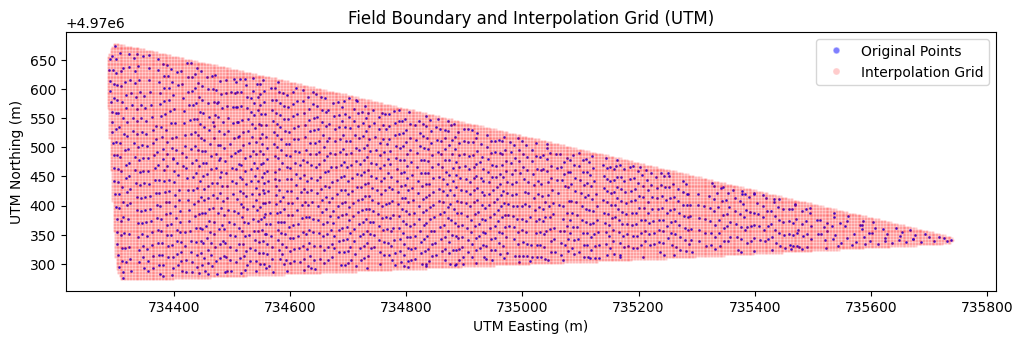

Number of original points: 1906
Number of interpolation grid points: 50095


In [8]:
# Plot to visualize
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data
gdf_utm.plot(ax=ax, color='blue', markersize=1, alpha=0.8, label='Original Points')
grid_points_within.plot(ax=ax, color='red', markersize=1, alpha=0.1, label='Interpolation Grid')

# Create legend entries manually
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Original Points', markerfacecolor='blue', markersize=5, alpha=0.5),
    plt.Line2D([0], [0], marker='o', color='w', label='Interpolation Grid', markerfacecolor='red', markersize=5, alpha=0.2)
]

ax.legend(handles=legend_elements)
ax.set_title('Field Boundary and Interpolation Grid (UTM)')
ax.set_xlabel('UTM Easting (m)')
ax.set_ylabel('UTM Northing (m)')
plt.show()

print(f"Number of original points: {len(gdf_utm)}")
print(f"Number of interpolation grid points: {len(grid_points_within)}")

## Yield Mapping: IDW - Inverse Distance Weighting

In [9]:
from scipy.spatial.distance import cdist
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

For our yield mapping, we'll use the Inverse Distance Weighting (IDW) interpolation method. IDW is a deterministic spatial interpolation technique that estimates unknown values based on known values at nearby locations.

Key principles of IDW:
1. Proximity: Closer known points have more influence on the estimated value.
2. Weighting: The influence of known points decreases with distance according to a power function.

Advantages of IDW:
- Simplicity: Easy to understand and implement.
- Efficiency: Computationally less intensive compared to some other methods.
- Local accuracy: Good at preserving local variations in the data.

Disadvantages:
- Sensitivity to outliers: Extreme values can have a strong influence on nearby estimates.
- Limited smoothing: May produce "bull's-eye" patterns around data points.
- No estimation of uncertainty: Unlike some geostatistical methods, IDW doesn't provide error estimates.

In [10]:
def idw_interpolation(known_points, known_values, unknown_points, p=2, max_distance=None):
    """
    Perform IDW interpolation.
    
    :param known_points: Array of known point coordinates
    :param known_values: Array of known point values
    :param unknown_points: Array of unknown point coordinates to interpolate
    :param p: Power parameter (default=2)
    :param max_distance: Maximum distance for interpolation (default=None)
    :return: Interpolated values for unknown points
    """
    distances = cdist(unknown_points, known_points)

    if max_distance is not None:
        distances[distances > max_distance] = np.inf

    weights = 1.0 / (distances ** p)
    weights_sum = np.sum(weights, axis=1, keepdims=True)

    # Handle cases where all weights are zero
    zero_weights = (weights_sum == 0).flatten()
    weights[zero_weights, :] = 1    # Set equal weights if all are zero
    weights_sum[zero_weights] = weights.shape[1]    # Sum of weights will be number of neighbors
    
    weights /= weights_sum
    return np.sum(weights * known_values, axis=1)


def cross_validate_idw(X, y, n_splits=5, **idw_params):
    """
    Perform cross-validation for IDW interpolation.
    
    :param X: Array of point coordinates
    :param y: Array of point values
    :param n_splits: Number of splits for K-Fold cross-validation
    :param p: Power parameter for IDW
    :return: Mean RMSE across all folds
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmse_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_pred = idw_interpolation(X_train, y_train, X_test, **idw_params)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

Parameter optimization:
We use cross-validation to find the best combination of:
- p: The power parameter controlling the decrease of influence with distance.
- max_distance: The maximum distance for interpolation.


In [11]:
# Prepare known points and values
X = gdf_utm[['X', 'Y']].values
y = gdf_utm['Yield_kg_m2'].values

# Optimize parameters
params_to_test = [
    {'p': p, 'max_distance': d}
    for p in np.linspace(1, 5, 11)
    for d in [10, 25, 50, 75, 100, 150, 200]
]

# Optimization via cross-validation
results = []
for params in params_to_test:
    rmse_scores = cross_validate_idw(X, y, **params)
    results.append((rmse_scores, params))

best_rmse, best_params = min(results, key=lambda x: x[0])
print(f"Best parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

# Extract X and Y coordinates from grid_points_within
grid_X = np.column_stack((grid_points_within.geometry.x, grid_points_within.geometry.y))

# Use the best parameters for final interpolation
interpolated_values = idw_interpolation(X, y, grid_X, **best_params)

# Add interpolated values to grid_points_within
grid_points_within.loc[:, 'interpolated_yield'] = interpolated_values

Best parameters: {'p': 1.0, 'max_distance': 50}
Best RMSE: 0.8383292365165321


Finally, we'll visualize our interpolated yield map. This visualization allows us to:
1. Identify spatial patterns in yield across the field.
2. Detect areas of high and low productivity.
3. Guide decision-making for precision agriculture practices.

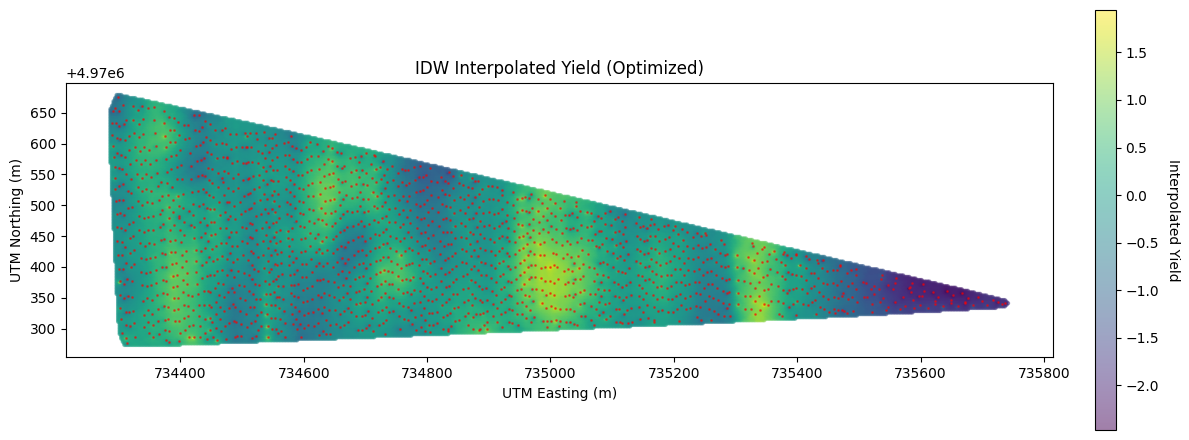

In [12]:
# Visualize results
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the interpolated yield values
scatter = ax.scatter(grid_points_within.geometry.x, 
                     grid_points_within.geometry.y, 
                     c=grid_points_within['interpolated_yield'], 
                     cmap='viridis', 
                     s=5, 
                     alpha=0.5)

# Plot the original yield values
gdf_utm.plot(ax=ax, color='red', markersize=1, alpha=0.5)

# Add colorbar with adjusted size and position
cbar = plt.colorbar(scatter, fraction=0.02, pad=0.04)
cbar.set_label('Interpolated Yield', rotation=270, labelpad=15)

ax.set_title('IDW Interpolated Yield (Optimized)')
ax.set_xlabel('UTM Easting (m)')
ax.set_ylabel('UTM Northing (m)')
plt.tight_layout()
plt.show()

Next steps:
- Validate results with ground-truth data if available.
- Combine with other spatial data (e.g., soil maps, elevation models) for more comprehensive analysis.
- Consider alternative interpolation methods (e.g., kriging) for comparison and uncertainty estimation.

While our dataset is well-suited for IDW interpolation due to its high granularity and relatively uniform distribution across the field (following the harvest machine's path), it's important to recognize the limitations of this method:

1. Isotropic assumption: IDW assumes that the influence of known points decreases uniformly in all directions (isotropy). However, our yield map shows clear directional patterns, likely corresponding to field characteristics or management practices. IDW cannot account for this anisotropy, potentially missing important spatial trends.

2. Lack of spatial continuity modeling: Unlike geostatistical methods such as Kriging, IDW doesn't model the spatial structure of the data. It can't capture the spatial autocorrelation or continuity that's evident in our yield patterns, particularly along certain directions (e.g., crop rows or soil gradients).

3. Oversimplification: By considering only distance, IDW may oversimplify complex spatial relationships in the yield data. Factors like topography, soil type, or microclimate variations that could influence yield patterns in specific directions are not accounted for.

To address these limitations, future work could explore more sophisticated interpolation methods like Kriging, which can model spatial continuity and anisotropy. Additionally, incorporating auxiliary variables (e.g., soil properties, elevation) could help capture the directional patterns we observe in the yield data.

### Saving the interpolated data

Now that we have our interpolated yield values, we can save them as a raster file for further analysis and comparison with other data in GIS software or Earth Engine.


In [13]:
import rasterio
from pyproj import Transformer
from shapely.geometry import Point
from rasterio.transform import from_origin

# Convert the points to EPSG:4326
crs_from = grid_points_within.crs
transformer = Transformer.from_crs(crs_from, "EPSG:4326", always_xy=True)

# Convert coordinates
grid_points_4326 = grid_points_within.copy()
grid_points_4326['geometry'] = grid_points_within.geometry.apply(
    lambda geom: Point(transformer.transform(geom.x, geom.y))
)

In [14]:
# Get the extent of your data in EPSG:4326
minx = grid_points_4326.geometry.x.min()
miny = grid_points_4326.geometry.y.min()
maxx = grid_points_4326.geometry.x.max()
maxy = grid_points_4326.geometry.y.max()

# Define the resolution (10 meters in degrees) - can be changed to 5 meters if needed
res = 10 / 111320

# Calculate the number of pixels
width = int((maxx - minx) / res) + 1
height = int((maxy - miny) / res) + 1

# Create an empty array to hold the raster data
raster_data = np.full((height, width), np.nan)

# Fill the array with interpolated values
for idx, row in grid_points_4326.iterrows():
    col = int((row.geometry.x - minx) / res)
    row_idx = int((maxy - row.geometry.y) / res)
    if 0 <= col < width and 0 <= row_idx < height:
        raster_data[row_idx, col] = row['interpolated_yield']

# Define the transform
transform = from_origin(minx, maxy, res, res)

# Save the raster
with rasterio.open('Data/interpolated_yield_4326.tif', 'w', driver='GTiff',
                   height=raster_data.shape[0], width=raster_data.shape[1],
                   count=1, dtype=rasterio.float32, crs='EPSG:4326',
                   transform=transform, nodata=np.nan) as dst:
    dst.write(raster_data.astype(rasterio.float32), 1)

print(f"Shape of saved raster: {raster_data.shape}")
print(f"Number of non-NaN points: {np.sum(~np.isnan(raster_data))}")
print(f"Percentage of non-NaN points: {np.sum(~np.isnan(raster_data)) / raster_data.size * 100:.2f}%")

Shape of saved raster: (41, 204)
Number of non-NaN points: 4570
Percentage of non-NaN points: 54.64%


This saving solution and file type may not be optimal or suitable for a comparison later on. Perhaps a better approach should be used.

## APPENDIX - VARIOGRAM

We will not delve into the calculation, fitting and interpretation of the variogram and of models like Kriging that are based on it. This is because we would need more time to fully understand the concepts of this model and how to apply it to our case. This is something that we are leaving for future work. We will just show the empirical calculation of the omnidirectional variogram to demonstrate that spatial continuity exists in our data.

In [14]:
from scipy.spatial.distance import pdist

def calculate_variogram(X, y, bins):
    """
    Calculate the empirical omnidirectional variogram.

    : param X: Array of point coordinates
    : param y: Array of yield values
    : param bins: Number of bins for distance classes
    : return: Tuple of bin centers and the corresponding variogram values
    """
    # Calculate pairwise distances
    distances = pdist(X)
    
    # Calculate squared differences of the target variable
    y_diff = pdist(y[:, None], metric='sqeuclidean')
    
    # Create distance classes
    min_dist = np.min(distances[distances > 0])     # Minimum non-zero distance
    max_dist = np.percentile(distances, 75)        # 75th percentile of distances
    bin_edges = np.linspace(min_dist, max_dist, bins + 1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    
    # Calculate variogram
    variogram = np.zeros(bins)
    for i in range(bins):
        mask = (distances >= bin_edges[i]) & (distances < bin_edges[i+1])
        if np.sum(mask) > 0:
            variogram[i] = np.mean(y_diff[mask]) / 2
    
    return bin_centers, variogram

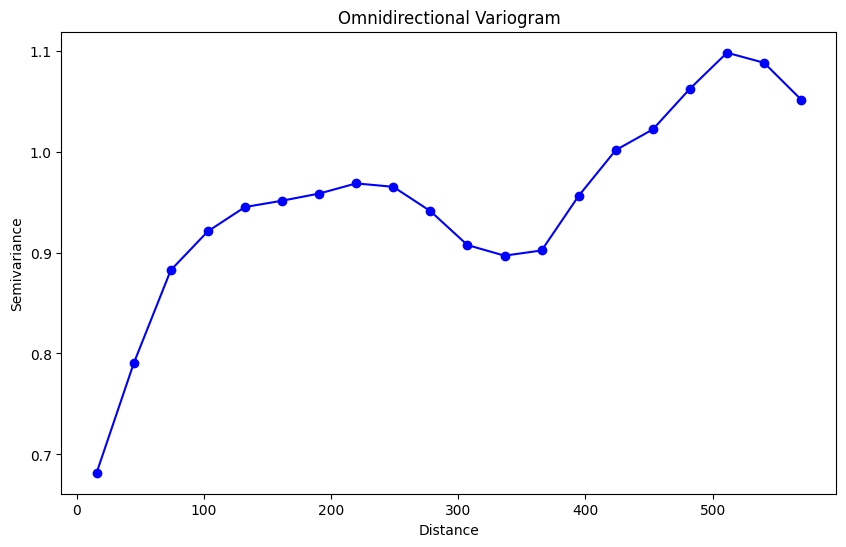

In [15]:
# Calculate variogram
X = gdf_utm[['X', 'Y']].values
y = gdf_utm['Yield_kg_m2'].values
bins = 20
bin_centers, variogram = calculate_variogram(X, y, bins)

# Plot variogram
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, variogram, 'bo-')
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.title('Omnidirectional Variogram')
plt.show()

This omnidirectional variogram reveals important spatial patterns in the yield data:
- The initial steep rise indicates strong spatial autocorrelation at short distances.
- The levelling off around 200-250 distance units suggests a range of spatial dependence.
- The slight dip and second rise may indicate nested spatial structures or cyclical patterns in the field.

Understanding these patterns can improve interpolation methods, guide sampling strategies, and provide insights into underlying factors affecting yield variability across the field.


TO BE CONTINUED...